In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import scipy.stats as stats
import math

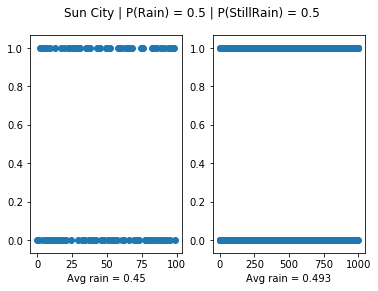

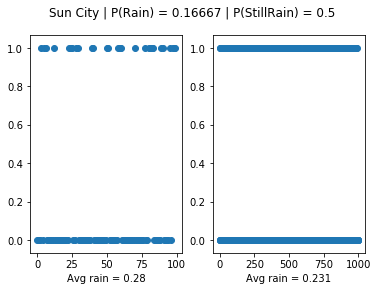

With P(rain) set to 1/3 the theoretical result of 0.25 is pretty sound.


In [65]:
#HW3 - Problem 1
def RunSunCity(sSize, pRain, pStillRain, numScenarios = 1):
    s = np.random.uniform(0,1,(numScenarios,sSize))
    res = np.zeros(s.shape)
    res[:,0] = s[:,0] < pRain
    for i in range(1,s.shape[1]):
        res[:,i] = int(res[:,i-1] == 1) * int(s[:,i] < pStillRain) + int(res[:,i-1] == 0) * int(s[:,i] < pRain)
    return res

def PlotSunCity(s1, s2, pRain, pStillRain):
    plt.suptitle("Sun City | P(Rain) = " + str(pRain) + " | P(StillRain) = " + str(pStillRain))
    plt.subplot(1,2,1)
    res1 = RunSunCity(s1, pRain, pStillRain)
    plt.scatter(range(0,s1),res1)
    plt.xlabel("Avg rain = " + str(res1.mean()))
    plt.subplot(1,2,2)
    res2 = RunSunCity(s2, pRain, pStillRain)
    plt.scatter(range(0,s2),res2)
    plt.xlabel("Avg rain = " + str(res2.mean()))
    plt.show()

PlotSunCity(100, 1000, 0.5, 0.5)
PlotSunCity(100, 1000, 0.16667, 0.5)
print('With P(rain) set to 1/3 the theoretical result of 0.25 is pretty sound.')

In [66]:
def RunIMA(sample, priorPdf, likelihood):
    t1 = sample[1:-1]
    t2 = sample[2:]
    r = likelihood(t1)*priorPdf(t2)/(likelihood(t2)*priorPdf(t1))
    u = np.random.uniform(0,1,r.size)
    for i in range(0,r.size):
        sample[i+1] = int(r[i] >= u[i]) * sample[i+1] + int(r[i] < u[i]) * sample[i]
    return sample[1:]

def PlotResults_P2_P3(res):
    print("Posterior Mean Estimate: " + str(res.mean()))
    x = np.array(range(1,res.size+1))
    cumMeans = np.cumsum(res)/x
    plt.subplot(1,3,2)
    plt.title('Cumulative means')
    plt.plot(x,cumMeans)
    plt.subplot(1,3,1)
    plt.title('Hist of Results')
    plt.hist(res)
    
    xAuto = np.arange(0,30,1)
    autoCorr = np.zeros(xAuto.shape)
    for i in xAuto:
        j = res.size - i
        autoCorr[i] = np.corrcoef(res[i:],res[:j])[0,1]
    plt.subplot(1,3,3)
    plt.title('Autocorrelations')
    plt.scatter(xAuto,autoCorr)
    plt.show()

Posterior Mean Estimate: 2.4390635599703345


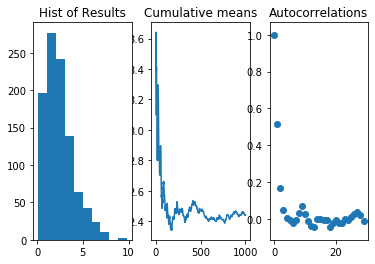

In [67]:
#HW3 - Problem 2
data = np.array([3,1,4,3,2])
def calculateGammaParams(data):
    shape = data.mean()**2/data.var()
    scale = data.var()/data.mean()
    return (shape, scale)

shape, scale = calculateGammaParams(data)
shape = 14
scale = 11/2
likelihood_p23 = lambda x: stats.gamma.pdf(x, shape, 0, 1/scale)

expMean = 2.55 ###
prior_p23 = lambda x: stats.expon.pdf(x, 0, expMean)
s_p23 = np.random.exponential(expMean,1001)

res_p2 = RunIMA(s_p23, prior_p23, likelihood_p23)
PlotResults_P2_P3(res_p2)

Posterior Mean Estimate: 2.9276464125198873


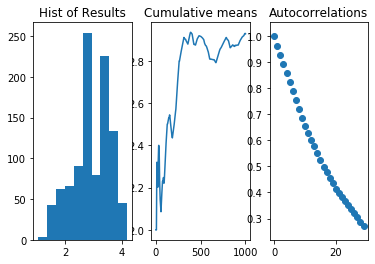

In [68]:
#HW3 - Problem 3
initPoint = 2 ###
sigma = 0.5

def RunRWIMA(init, sigma, likelihood, samples = 1000):
    res = np.ones(samples+1)*init
    u = np.random.uniform(0,1,samples+1)
    for i in range(1,samples):
        s = np.random.normal(res[i-1], sigma)
        r = likelihood(s)/(res[i-1])
        res[i] = int(r >= u[i]) * s + int(r < u[i]) * res[i-1]
    return res[1:]

res_p3 = RunRWIMA(initPoint, sigma, likelihood_p23)
PlotResults_P2_P3(res_p3)

In [75]:
#HW3 - Problem 4
def CalcGeweke(res):
    n10 = int(0.1*res.size)
    n50 = int(0.5*res.size)
    return np.abs(res[:n10].mean() - res[n50:].mean())

print('P2 Geweke statistic: ' + str(CalcGeweke(res_p2)))
print('P3 Geweke statistic: ' + str(CalcGeweke(res_p3)))

P2 Geweke statistic: 0.11938582269187226
P3 Geweke statistic: 0.6496319783830433


In [109]:
#HW3 - Problem 5
n = 10
s = 1000
res_p5_ima = np.zeros((n, s))
res_p5_rwima = np.zeros((n, s))
for i in range(0,n):
    s_p5 = np.random.exponential(expMean,s+1)
    res_p5_ima[i,:] = RunIMA(s_p5, prior_p23, likelihood_p23)
    res_p5_rwima[i,:] = RunRWIMA(initPoint, sigma, likelihood_p23,s)

def CalcGelmanRubin(res):
    n50 = int(res.shape[1]/2)
    res = res[:,n50:]
    vars = np.var(res, axis=0)
    meanOfVar = vars.mean()
    means = np.mean(res, axis=0)
    varOfMeans = means.var()
    v = (1-2/res.shape[0])*meanOfVar+(2/res.shape[0])*varOfMeans
    return (v/meanOfVar)**0.5, meanOfVar, varOfMeans
res_p5 = pd.DataFrame(np.array([CalcGelmanRubin(res_p5_ima),CalcGelmanRubin(res_p5_rwima)]),columns=['Shrink Factor','Mean Of Var','Var of Means'],index=['P2_ima','P3_rwima'])
print(res_p5)
print('Similar shrink factor across both methods but ima has more variance')

Shrink Factor  Mean Of Var  Var of Means
P2_ima         0.907461     2.617330      0.307339
P3_rwima       0.899733     0.346289      0.016483
Similar shrink factor across both methods but ima has more variance
